In [88]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch import optim as optim
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
from skimage import io
import os

# Set random seed for reproducibility
manualSeed = 42
torch.manual_seed(manualSeed)

In [54]:
# Batch size during training
batch_size = 140

# Image size 
image_size = 160

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of y label vector
ny = 2

# Number of training epochs
num_epochs = 200

# Image saving interval
interval = 10

# Learning rate for optimizers
lr = 0.0002

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
class FontDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.fonts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fonts_frame)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.fonts_frame.iloc[idx, 0])

        image = io.imread(img_path)
        font_attributes = self.fonts_frame.iloc[idx, 1:]
        font_attributes = np.array([font_attributes])
        font_attributes = font_attributes.astype("int").reshape(-1, 3)

        if self.transform:
            image = self.transform(image)

        return image, font_attributes


In [57]:
data_loader = torch.utils.data.DataLoader(FontDataset(csv_file="A_1/Fonts.csv", 
                            root_dir="A_1/PNG/", 
                            transform=transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Pad(30, 255),
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                 (0.5,), (0.5,))
                            ])),
  batch_size=batch_size, shuffle=True);

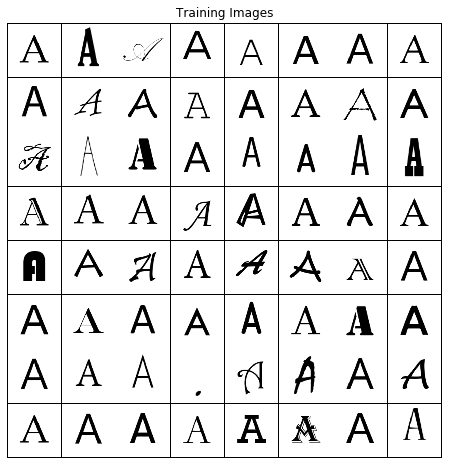

In [58]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [59]:
class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()
        input_dim = nz + ny
        output_dim = image_size**2
        self.label_embedding = nn.Embedding(ny, ny)
        
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x,c], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output.to(device)

In [60]:
class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()
        input_dim = image_size ** 2 + ny
        output_dim = 1
        self.label_embedding = nn.Embedding(ny, ny)

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)

        return output.to(device)

In [61]:
generator = GeneratorModel()

generator.to(device)

GeneratorModel(
  (label_embedding): Embedding(2, 2)
  (hidden_layer1): Sequential(
    (0): Linear(in_features=102, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer4): Sequential(
    (0): Linear(in_features=1024, out_features=25600, bias=True)
    (1): Tanh()
  )
)

In [62]:
discriminator = DiscriminatorModel()

discriminator.to(device)

DiscriminatorModel(
  (label_embedding): Embedding(2, 2)
  (hidden_layer1): Sequential(
    (0): Linear(in_features=25602, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden_layer2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden_layer3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden_layer4): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [63]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr=lr)

optimizerD = optim.Adam(discriminator.parameters(), lr=lr)

# fixed noise & label
fixed_noise = torch.randn(64, nz).to(device)
fixed_label = torch.randint(0, ny, (64,)).to(device)

In [64]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(data_loader):

        ##################################
        # (1) Update Discriminator network
        ##################################

        ## Train with all-real batch
        discriminator.zero_grad()       
        # image data
        b_size = data[0].size()[0]
        real_data = data[0].view(b_size, image_size**2).to(device)
        # TODO plt.imshow(real_data.squeeze(), cmap="gray") # TODO Test
        real_style = data[1].squeeze()[:, 0].to(device)
        # labels
        y_real = torch.ones(b_size).to(device)
        y_fake = torch.zeros(b_size).to(device)
        # Forward pass real batch through D
        output = discriminator(real_data, real_style).view(b_size)
        # Calculate loss on all-real batch
        errD_real = criterion(output, y_real)


        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size,nz).to(device)
        # Generate batch of fake digits
        fake_style = torch.randint(0, ny, (b_size,)).to(device)
        # Generate fake image batch with G
        fake_data = generator(noise, fake_style)
        # Forward pass fake btach through D
        output = discriminator(fake_data.detach(), fake_style).view(b_size)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, y_fake)
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Calculate gradients for D in backward pass
        errD.backward()
        # Update D
        optimizerD.step()

        ##################################
        # (2) Update G network
        ##################################

        generator.zero_grad()
        # # Generate batch of latent vectors
        noise = torch.randn(b_size,nz).to(device)
        # # Generate batch of fake digits
        fake_style = torch.randint(0, ny, (b_size,)).to(device)
        # #  Generate fake image batch with G
        fake_data = generator(noise, fake_style)
        # Forward pass fake btach through D
        output = discriminator(fake_data, fake_style).view(b_size)
        # Calculate G's loss based on this output
        errG = criterion(output, y_real)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        
       # Output training stats 
        if i % len(data_loader) == 0:
            print(f"[{epoch+1}/{num_epochs}] \tLoss_D: {errD.item():.4f}\t Loss_G: {errG.item():.4f}")

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed noise
        if (epoch % interval == 0) and (i % len(data_loader) == 0):
            with torch.no_grad():
                fake = generator(fixed_noise, fixed_label).detach().view(64, 1, image_size, image_size).to(device)
            img_list.append(vutils.make_grid(fake, normalize=True))
            
        iters += 1

[1/200] 	Loss_D: 1.3699	 Loss_G: 0.6947
[2/200] 	Loss_D: 0.7272	 Loss_G: 0.6718
[3/200] 	Loss_D: 0.7725	 Loss_G: 0.6435
[4/200] 	Loss_D: 0.8183	 Loss_G: 0.6218
[5/200] 	Loss_D: 0.8623	 Loss_G: 0.6245
[6/200] 	Loss_D: 0.8433	 Loss_G: 0.6833
[7/200] 	Loss_D: 0.7664	 Loss_G: 0.8250
[8/200] 	Loss_D: 1.1172	 Loss_G: 0.6850
[9/200] 	Loss_D: 0.8008	 Loss_G: 0.5401
[10/200] 	Loss_D: 1.0137	 Loss_G: 0.4448
[11/200] 	Loss_D: 1.2561	 Loss_G: 0.3888
[12/200] 	Loss_D: 1.3949	 Loss_G: 0.4300
[13/200] 	Loss_D: 1.3308	 Loss_G: 0.5147
[14/200] 	Loss_D: 1.2066	 Loss_G: 0.6957
[15/200] 	Loss_D: 1.4311	 Loss_G: 0.6884
[16/200] 	Loss_D: 1.4790	 Loss_G: 0.5316
[17/200] 	Loss_D: 1.3639	 Loss_G: 0.3840
[18/200] 	Loss_D: 1.5041	 Loss_G: 0.3350
[19/200] 	Loss_D: 1.5592	 Loss_G: 0.3915
[20/200] 	Loss_D: 1.4632	 Loss_G: 0.5619
[21/200] 	Loss_D: 1.2147	 Loss_G: 0.8519
[22/200] 	Loss_D: 1.0802	 Loss_G: 1.1133
[23/200] 	Loss_D: 0.9999	 Loss_G: 1.2590
[24/200] 	Loss_D: 0.8205	 Loss_G: 1.2651
[25/200] 	Loss_D: 0.6109	

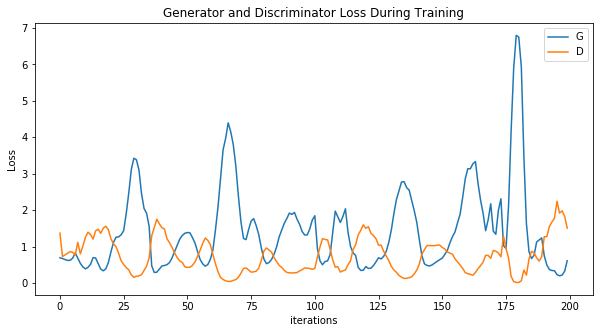

In [65]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

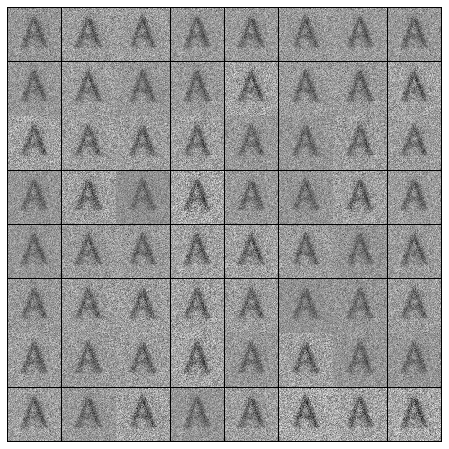

In [66]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

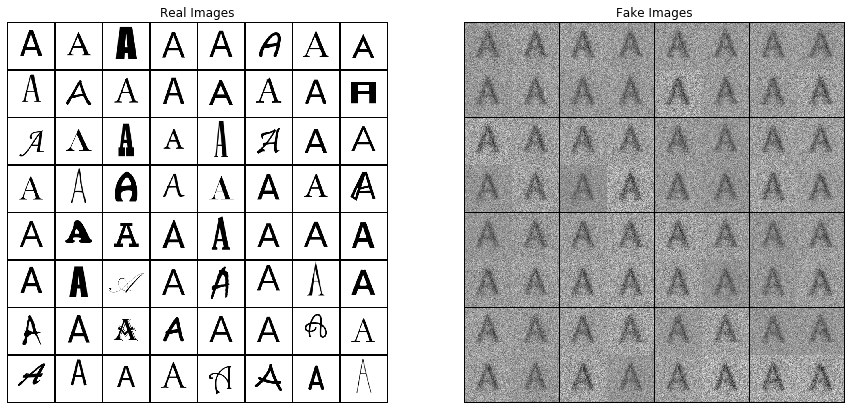

In [67]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(data_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [68]:
torch.save(generator.state_dict(), "models/Generator_cGAN_Fonts")
torch.save(discriminator.state_dict(), "models//Discriminator_cGAN_Fonts")

In [69]:
generator = GeneratorModel()
generator.load_state_dict(torch.load("models/Generator_cGAN_Fonts"))

discriminator = DiscriminatorModel()
discriminator.load_state_dict(torch.load("models/Discriminator_cGAN_Fonts"))

<All keys matched successfully>

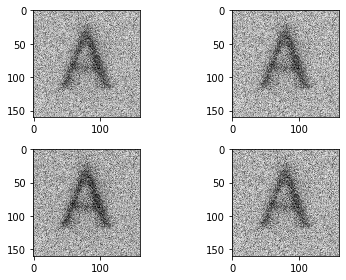

In [101]:
noise = torch.randn(4, nz).to(device)
labels = torch.tensor([0, 1, 0, 1])
generated_data = generator(noise, labels).view(4, 160, 160)

fig = plt.figure()

for i, x in enumerate(generated_data):
    ax = plt.subplot(2, 2, i+1)
    plt.tight_layout()
    plt.imshow(x.detach().numpy(), interpolation="nearest", cmap ="gray")

plt.show()